In [1]:
import gzip
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
path = "/Users/lukelotshakulongo/Desktop/Bankoko/Lecture/Fastai/DLConcepts/Autoencoder/data"

In [5]:
# Funktionen zum Laden der Daten
def open_images(filename):
    with gzip.open(filename, "rb") as file:
        data = file.read()
        return np.frombuffer(data, dtype=np.uint8, offset=16)\
            .reshape(-1, 28, 28).astype(np.float32)

# Lade und normalisiere Bilder
Y_train = open_images(f"{path}/mnist/train-images-idx3-ubyte.gz") / 255.
Y_test = open_images(f"{path}/mnist/t10k-images-idx3-ubyte.gz") / 255.

In [11]:
# Füge raischen hinzu
# Füge Rauschen hinzu
X_train = Y_train + np.random.normal(0, 0.2, Y_train.shape)
X_test = Y_test + np.random.normal(0, 0.2, Y_test.shape)

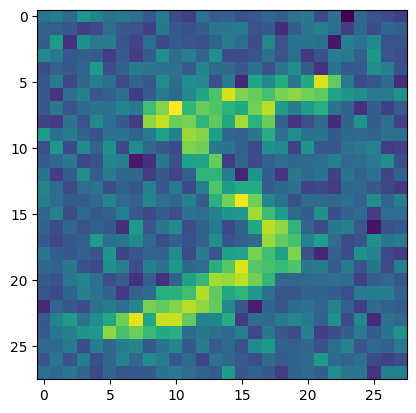

In [12]:
plt.imshow(X_train[0])
plt.show()

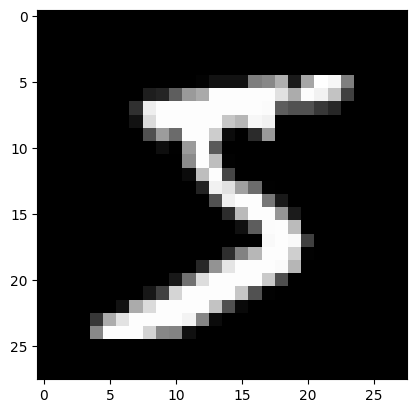

In [20]:
plt.imshow(Y_train[0], cmap="gray")
plt.show()

In [23]:
# Clipping auf gültige Werte
# Alle Werte kleiner als min werden auf min gesetzt, und alle Werte größer als max auf max
# Nach dem Hinzufügen von Rauschen zu den Bildern:

X_train = np.clip(X_train, 0., 1.)
X_test = np.clip(X_test, 0., 1.)

In [25]:
X_train.shape

(60000, 28, 28)

In [26]:
# Umwandlung in Torch-Tensoren
X_train = torch.tensor(X_train).unsqueeze(1)  # (N, 1, 28, 28)
Y_train = torch.tensor(Y_train).unsqueeze(1)
X_test = torch.tensor(X_test).unsqueeze(1)
Y_test = torch.tensor(Y_test).unsqueeze(1)

In [27]:
X_train.shape # wichtig verstehen

torch.Size([60000, 1, 28, 28])

In [28]:
# Dataloader
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=32)

In [31]:
# Autoencoder ohne nn.Sequential
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder-Teil
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.pool1 = nn.MaxPool2d(2)                            # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(1, 2, kernel_size=3, padding=1)  # 14x14 -> 14x14
        self.pool2 = nn.MaxPool2d(2)                            # 14x14 -> 7x7

        # Decoder-Teil
        self.deconv1 = nn.Conv2d(2, 2, kernel_size=3, padding=1)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')  # 7x7 -> 14x14
        self.deconv2 = nn.Conv2d(2, 4, kernel_size=3, padding=1)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')  # 14x14 -> 28x28
        self.deconv3 = nn.Conv2d(4, 1, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        # Decoder
        x = self.relu(self.deconv1(x))
        x = self.up1(x)
        x = self.relu(self.deconv2(x))
        x = self.up2(x)
        x = self.sigmoid(self.deconv3(x))
        return x


In [37]:
model = Autoencoder()
criterion = nn.MSELoss() # Loss
optimizer = optim.RMSprop(model.parameters(), lr=0.001) # SGD ist auch möglich

In [38]:
# Training
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

RuntimeError: Input type (double) and bias type (float) should be the same